<a href="https://colab.research.google.com/github/AlexKressner/Business_Intelligence/blob/main/ML_Fallstudie_Online_Barber_Shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study "Online Barber Shop"
Sie finden unter `./Daten/Barber/` den Ausschnitt eines Datensatzes einer **Direct-to-Consumer (D2C) Brand**, die über einen Onlineshop **Rasierer** und **Rasierzubehör** verkauft. Für das Unternehmen ist es enorm wichtig, dass es die voraussichtlichen **Absätze der nächsten 21 Tage** kennt, da es Waren im Voraus bei seinen Lieferanten bestellen muss. Je genauer die Absatzprognose, desto weniger Stockouts bzw. unnötige Bestände hat das Unternehmen und desto besser die Marge.

Bisher ist es dem Unternehmen nicht gelungen, gute Prognosen zu erstellen. Um dies zu ändern, werden Sie nun beauftragt, eine Prognose mithilfe von ML-Algorithmen anzufertigen. Dazu stellt Ihnen das Unternehmen einen ersten Datensatz aus seinem Shopsystem zur Verfügung. In diesem sind **3 Produkte** enthalten (Alaunstein, Bartbalm und ein Rasierer) und Sie sollen für diese jeweils eine Absatzprogonse erstellen. Bitte orientieren Sie sich bei der Bearbeitung der Fallstudie an der in diesem Notebook vorgeschlagenen Struktur und greifen Sie auf die Notebooks zurück, die wir bereits in der Vorlesung gemeinsam bearbeitet haben.

Die Struktur Ihres Notebooks sollte dabei wie folgt aussehen und u.a. die folgenden Fragen beantworten:

1. **Daten laden & aufbereiten**. Wichtig: Nachdem Sie die Daten geladen haben, müssen Sie diese zunächst auf Tage und je Produkt aggregieren.
2. **Datenexploration**, d.h. verschaffen Sie sich einen Überblick zum Datensatz. Sie sollten folgende Fragen beantworten:
  - Wie viele Absätze wurden über welchen Zeitraum je Produkt dokumentiert?
  - Was ist der Gesamtumsatz je Produkt?
  - Wie sind die Produktverkäufe im Zeitverlauf? Visualisieren Sie beispielweise die monatlichen/wöchentlichen Verkaufsmengen. Dies ist wichtig, um Trends oder Saisonalität in Zeitreihen zu erkennen.
  - Wie sind die durchschnittlichen Absätze pro Wochentag?
3. **Feature Engineering**
  - Entwickeln Sie basirend auf Ihrer Datenexploration nützliche Features für ein Vorhersagemodell.
  - Stellen Sie sich die Frage, mit welchen Features Sie Saisonalitäten abbilden können. Gibt es Monate in den die Absätze deutlich höher sind? Falls ja, sollten Sie ein Features einführen, das den Monat (Jan, Feb, ..., Dez) abbildet!
  - Bilden Sie autoregressive Features, z.B. könnte es Sinn ergeben zur Progonse des Absatzes an einem Tag (z.B. 15.03.) den Absatz des Vormonats zum gleichen Datum (15.02.) heranzuziehen.
  - Können Sie aus den zur Verfügung stehenden Daten den Stückpreis als Feature ableiten?
4. **Prognosemodell trainieren und bewerten**
  - Trainieren Sie ein globales Prognosemodell auf allen Daten und bewerten Sie dieses.
  - Trainieren Sie drei lokale Prognosemodelle (für Alaunstein, Bartbalm & Rasierer) und überprüfen Sie, ob die Prognosegüte verbessert wird.


In [62]:
! ls

Business_Intelligence  sample_data


In [63]:
! git clone https://github.com/AlexKressner/Business_Intelligence

fatal: destination path 'Business_Intelligence' already exists and is not an empty directory.


In [64]:
! ls Business_Intelligence/Daten/Barber

barber_shopify_data.csv


## 1 Daten laden und aufbereiten

In [65]:
import pandas as pd
import numpy as np

In [66]:
data = pd.read_csv("Business_Intelligence/Daten/Barber/barber_shopify_data.csv", sep=";", parse_dates=["Datum"], decimal=",")

In [67]:
data.head(10)

,Datum,Produkt,Nettomenge,Bruttoumsatz
0,2020-01-07,Alaunstein,0,8.40
1,2020-02-07,Alaunstein,0,8.40
2,2020-03-07,Alaunstein,0,8.40
3,2020-04-07,Alaunstein,0,8.40
4,2020-05-07,Alaunstein,1,8.39
5,2020-06-07,Alaunstein,3,25.19
6,2020-07-07,Alaunstein,5,43.07
7,2020-08-07,Alaunstein,1,8.62
8,2020-09-07,Alaunstein,2,17.22
9,2020-10-07,Alaunstein,2,17.22


In [68]:
data = data.groupby(["Datum","Produkt"], sort=False)[["Nettomenge","Bruttoumsatz"]].sum().reset_index()

In [69]:
data.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz
0,2020-01-07,Alaunstein,0,8.40
1,2020-02-07,Alaunstein,0,8.40
2,2020-03-07,Alaunstein,0,8.40
3,2020-04-07,Alaunstein,0,8.40
4,2020-05-07,Alaunstein,1,8.39


## 2 Datenexploration (kurz)

In [70]:
data.groupby("Produkt")["Datum"].agg(["min", "count", "max"])

,min,count,max
Produkt,,,
Alaunstein,2020-01-07,761,2022-12-07
Bartbalm Crusoe,2021-01-11,92,2022-12-07
Rasierhobel Solingen Stahl - Set,2021-12-14,230,2022-12-07


In [71]:
data.groupby("Produkt")[["Nettomenge","Bruttoumsatz"]].sum().reset_index()

,Produkt,Nettomenge,Bruttoumsatz
0,Alaunstein,3320,30115.98
1,Bartbalm Crusoe,105,3483.49
2,Rasierhobel Solingen Stahl - Set,110,27443.80


<Axes: xlabel='Datum'>

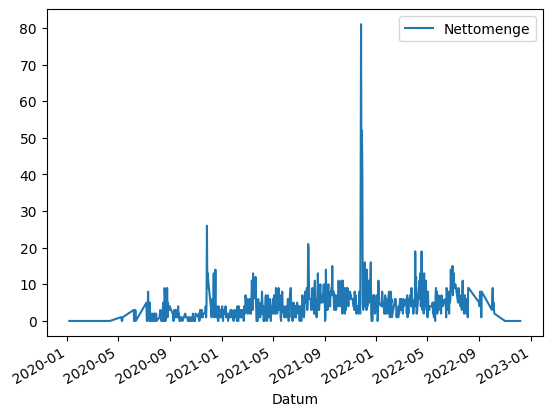

In [72]:
# Tagesumsätze
data[data["Produkt"]=="Alaunstein"].plot(kind="line", x="Datum", y="Nettomenge")

<Axes: xlabel='Datum'>

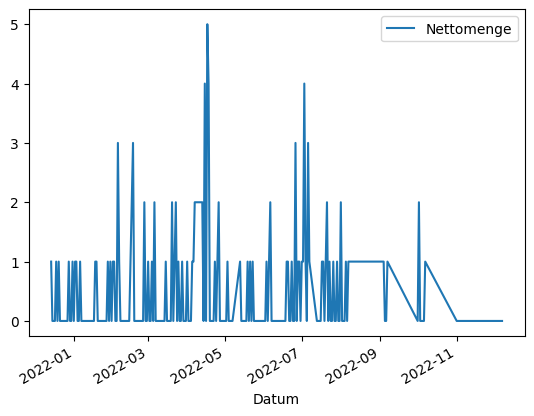

In [73]:
# Tagesumsätze
data[data["Produkt"]=="Rasierhobel Solingen Stahl - Set"].plot(kind="line", x="Datum", y="Nettomenge")

<Axes: xlabel='Datum'>

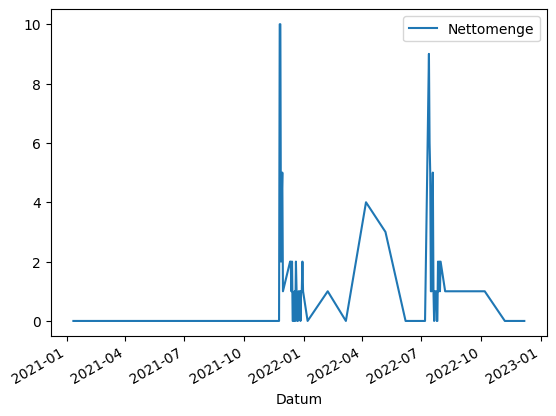

In [74]:
# Tagesumsätze
data[data["Produkt"]=="Bartbalm Crusoe"].plot(kind="line", x="Datum", y="Nettomenge")

In [75]:
data["Wochentag"] = data["Datum"].dt.dayofweek

In [76]:
data.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Wochentag
0,2020-01-07,Alaunstein,0,8.40,1
1,2020-02-07,Alaunstein,0,8.40,4
2,2020-03-07,Alaunstein,0,8.40,5
3,2020-04-07,Alaunstein,0,8.40,1
4,2020-05-07,Alaunstein,1,8.39,3


In [77]:
data.pivot_table(index="Wochentag", columns="Produkt", values="Nettomenge", aggfunc="mean")

Produkt,Alaunstein,Bartbalm Crusoe,Rasierhobel Solingen Stahl - Set
Wochentag,,,
0,4.724771,0.866667,0.484848
1,3.611111,0.833333,0.437500
2,3.275229,1.166667,0.454545
3,3.871560,1.642857,0.352941
4,4.495413,1.500000,0.484848
5,4.657407,1.000000,0.343750
6,5.899083,0.923077,0.787879


## 3 Feature Engineering

In [78]:
# Einfaches Feature Engineering
data["Wochentag"] = data["Datum"].dt.dayofweek
data["Monat"] = data["Datum"].dt.month
data["Woche"] = data["Datum"].dt.isocalendar().week
data["Stueckpreis"] = data["Bruttoumsatz"] / data["Nettomenge"]
data.tail()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Wochentag,Monat,Woche,Stueckpreis
1078,2022-07-27,Rasierhobel Solingen Stahl - Set,0,75.62,2,7,30,inf
1079,2022-07-28,Rasierhobel Solingen Stahl - Set,0,75.62,3,7,30,inf
1080,2022-07-29,Rasierhobel Solingen Stahl - Set,1,75.62,4,7,30,75.62
1081,2022-07-30,Rasierhobel Solingen Stahl - Set,0,75.62,5,7,30,inf
1082,2022-07-31,Rasierhobel Solingen Stahl - Set,0,75.62,6,7,30,inf


In [79]:
# Unendlich (inf) durch nicht-verfügbar (NaN) ersetzen
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [80]:
data.tail()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Wochentag,Monat,Woche,Stueckpreis
1078,2022-07-27,Rasierhobel Solingen Stahl - Set,0,75.62,2,7,30,NaN
1079,2022-07-28,Rasierhobel Solingen Stahl - Set,0,75.62,3,7,30,NaN
1080,2022-07-29,Rasierhobel Solingen Stahl - Set,1,75.62,4,7,30,75.62
1081,2022-07-30,Rasierhobel Solingen Stahl - Set,0,75.62,5,7,30,NaN
1082,2022-07-31,Rasierhobel Solingen Stahl - Set,0,75.62,6,7,30,NaN


In [81]:
# Nicht-verfügbare Preise "nach vorne" auffüllen (forward-fill = ffill)
data.sort_values(by=["Produkt","Datum"], inplace=True)
data['Stueckpreis'] = data.groupby('Produkt')['Stueckpreis'].ffill()

In [82]:
data.tail()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Wochentag,Monat,Woche,Stueckpreis
941,2022-12-03,Rasierhobel Solingen Stahl - Set,0,89.99,5,12,48,75.62
972,2022-12-04,Rasierhobel Solingen Stahl - Set,0,75.62,6,12,48,75.62
1002,2022-12-05,Rasierhobel Solingen Stahl - Set,0,75.61,0,12,49,75.62
1033,2022-12-06,Rasierhobel Solingen Stahl - Set,0,226.86,1,12,49,75.62
1063,2022-12-07,Rasierhobel Solingen Stahl - Set,0,75.62,2,12,49,75.62


In [83]:
data.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz,Wochentag,Monat,Woche,Stueckpreis
0,2020-01-07,Alaunstein,0,8.40,1,1,2,NaN
31,2020-01-08,Alaunstein,0,17.24,2,1,2,NaN
62,2020-01-09,Alaunstein,0,34.46,3,1,2,NaN
92,2020-01-10,Alaunstein,0,8.61,4,1,2,NaN
123,2020-01-11,Alaunstein,0,17.22,5,1,2,NaN


In [84]:
data.dropna(inplace=True)

In [85]:
# Bruttoumsatz und Datum entfallen lassen
data.drop(columns=["Bruttoumsatz","Datum"], inplace=True)
data.head()

,Produkt,Nettomenge,Wochentag,Monat,Woche,Stueckpreis
4,Alaunstein,1,3,5,19,8.39
35,Alaunstein,1,4,5,19,8.39
66,Alaunstein,1,5,5,19,8.39
96,Alaunstein,0,6,5,19,8.39
127,Alaunstein,0,0,5,20,8.39


## 4 Modell trainieren und bewerten

In [86]:
X = data.drop(columns="Nettomenge")
y = data["Nettomenge"]

In [87]:
X = pd.get_dummies(X)

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
# Training Algorithmus: X_train (Features), y_train (Target)
# Test des Algorithmus (Bewertung): X_test, y_test
#     1) Algorithmus bekommt Daten (X_test), die er noch nicht kennt & macht Prognose
#     2) Vergleich Prognose mit tatsächlichen Werte (y_test) --> Bewertung

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [90]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
model = RandomForestRegressor()

In [92]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [93]:
X_test.head()

,Wochentag,Monat,Woche,Stueckpreis,Produkt_Alaunstein,Produkt_Bartbalm Crusoe,Produkt_Rasierhobel Solingen Stahl - Set
930,0,1,1,92.43000,0,0,1
840,1,7,29,21.79800,0,1,0
1042,1,6,25,75.62000,0,0,1
640,4,2,5,8.58875,1,0,0
199,5,1,2,8.39000,1,0,0


In [94]:
y_pred = model.predict(X_test)

In [95]:
y_pred[:5]

array([0.16      , 2.66      , 0.55      , 7.85      , 2.77452381])

In [96]:
import sklearn.metrics
import matplotlib.pyplot as plt

In [97]:
# Genauigkeit des Modells auf der Testmenge, mittlerer absoluter Fehler
sklearn.metrics.mean_absolute_error(y_test, y_pred)

1.5126765389082466

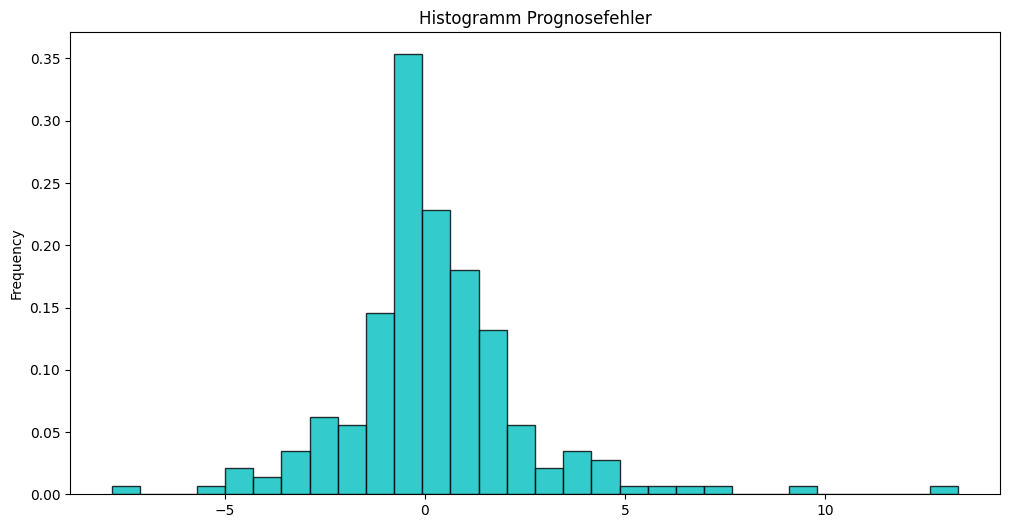

In [99]:
(y_test - y_pred).plot(
    kind="hist",
    title= "Histogramm Prognosefehler",
    figsize=(12,6),
    color="c",
    edgecolor='k',
    density=True,
    alpha=0.8,
    bins=30
    )
plt.show()